In [1]:
#Compare obtained plots whith plot the plots that only include aligment with len/qlen > 90 
# Use namasivayam seqs for testing

In [2]:
import os
import argparse
import subprocess
import pandas as pd  # Import pandas

In [3]:
def function_body(input_sequence_blocks, input_subject_sequences,
                  output_continuos_coverage_tsv, output_non_nam_seqs_dir, params_threads,
                  params_word_size):

    # Creating the output directory
    output_dir = os.path.dirname(output_continuos_coverage_tsv)
    os.makedirs(output_dir, exist_ok=True)

    # Create the BLAST database
    if not os.path.isfile(input_subject_sequences):
        raise FileNotFoundError(f"Subject sequences file not found: {input_subject_sequences}")

    # Create BLAST database
    blast_db_path = os.path.join(output_dir, 'blast_db')
    try:
        subprocess.run(
            [
                'makeblastdb',
                '-in', input_subject_sequences,
                '-out', blast_db_path,
                '-dbtype', 'nucl'
            ],
            check=True,
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL
        )
        print(f"BLAST database created at: {blast_db_path}")
    except subprocess.CalledProcessError as e:
        print(f"Error creating BLAST database: {e}")

    # Run the BLAST search
    if not os.path.isfile(input_sequence_blocks):
        raise FileNotFoundError(f"Sequence blocks file not found: {input_sequence_blocks}")

    blast_output_path = os.path.join(output_dir, 'blast.blocks_x_subject.tsv')
    try:
        print("Running BLAST alignment...")
        subprocess.run(
            [
                'blastn',
                '-query', input_sequence_blocks,
                '-db', blast_db_path,
                '-out', blast_output_path,
                '-outfmt', '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore slen qlen',
                '-perc_identity', '90',
                '-num_threads', str(params_threads),
                '-word_size', str(params_word_size)
            ],
            check=True
        )
        print(f"BLAST results saved to: {blast_output_path}")
    except subprocess.CalledProcessError as e:
        print(f"BLAST search failed: {e}")

    # Load BLAST results into a Pandas DataFrame
    # Define column headers for the BLAST output (outfmt 6)
    blast_columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen',
                     'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'slen', 'qlen']

    # Read the BLAST output file into a DataFrame
    blast_results_df = pd.read_csv(blast_output_path, sep='\t', header=None, names=blast_columns)

    # Optionally, filter the BLAST results
    # blast_results_df = blast_results_df[blast_results_df['length'] / blast_results_df['qlen'] > 0.90]

    # Save the DataFrame to a TSV file (optional)
    blast_results_df.to_csv(output_continuos_coverage_tsv, sep='\t', index=False)

    # Load homemade Python functions
    import sys

    current_dir = os.getcwd()
    utils_dir = os.path.join(current_dir, 'utils')
    sys.path.append(utils_dir)

    from blast_utils import alignment_absolute_start_end, total_coverage

    # Obtain the absolute positions of each query alignment in each subject
    sorted_df = alignment_absolute_start_end(blast_results_df).sort_values(['sseqid', 'a.sstart', 'a.send'])

    total_coverage_s = sorted_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject')).reset_index(name='coverage_fraction')
    coverage_df = pd.merge(sorted_df, total_coverage_s, on='sseqid', how='left')
    plot_df = pd.merge(sorted_df, total_coverage_s, on='sseqid', how='left')[['sseqid', 'coverage_fraction', 'slen']].drop_duplicates('sseqid')

    from Bio import SeqIO

    # Create output directory for sequences not meeting the NAM criteria
    non_Nam_dir = os.path.dirname(output_non_nam_seqs_dir)
    os.makedirs(non_Nam_dir, exist_ok=True)
    non_nam_file_name = f"Non_nam.{os.path.basename(input_subject_sequences)}"
    non_nam_file = os.path.join(non_Nam_dir, non_nam_file_name)

    # Use context managers correctly for both input and output FASTA files
    with open(input_subject_sequences, 'r') as fasta, open(non_nam_file, 'w') as out_fasta:
        q = 0
        subject_set = set(plot_df['sseqid'])  # Changed to 'sseqid' to match the DataFrame column
        for record in SeqIO.parse(fasta, "fasta"):
            q += 1
            if record.id not in subject_set:
                out_fasta.write(f">{record.id}\n{record.seq}\n")

    print(f'Sequences without Namasivayam blocks saved in: {non_nam_file}')
    
    total_sequences = q
    nam_sequences = plot_df[plot_df["coverage_fraction"] > 0.50].shape[0]

    import matplotlib.pyplot as plt

    print(f"Total number of sequences: {total_sequences}")
    print(f"Number of NAM sequences: {nam_sequences}")
    print(f"Proportion of NAM fragments: {nam_sequences / total_sequences:.2f}")
    print(f"Median size: {plot_df['slen'].median()}")
    print(f"Mean size: {plot_df['slen'].mean()}")
    print(f"Median coverage: {plot_df['coverage_fraction'].median()}")
    print(f"Mean coverage: {plot_df['coverage_fraction'].mean()}")

    plt.figure(figsize=(18, 8))
    plt.scatter(plot_df['slen'], plot_df['coverage_fraction'], alpha=0.6, s=10)
    plt.xlabel('Sequence Length (slen)')
    plt.ylabel('Total Coverage')
    plt.title(f'Coverage with NAMs Fragments vs. Sequence Length for\n{os.path.basename(input_subject_sequences)}')
    plt.xlim((0, 75000))
    plt.ylim((0, 1.05))
    plt.grid(True)
    # plt.savefig(output_plot_path)
    plt.show()
    
    return(blast_results_df, nam_sequences, total_sequences)


Developer mode activated!
Developer mode activated!
BLAST database created at: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/blast_db
Running BLAST alignment...
BLAST results saved to: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/blast.blocks_x_subject.tsv


/tmp/ipykernel_2348643/585130760.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_s = sorted_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject')).reset_index(name='coverage_fraction')


Sequences without Namasivayam blocks saved in: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/non_nam/Non_nam.toxo1.size_filtered.fasta
Total number of sequences: 128876
Number of NAM sequences: 1314
Proportion of NAM fragments: 0.01
Median size: 2819.0
Mean size: 6815.790262172284
Median coverage: 0.6645692158760891
Mean coverage: 0.5712690548587971


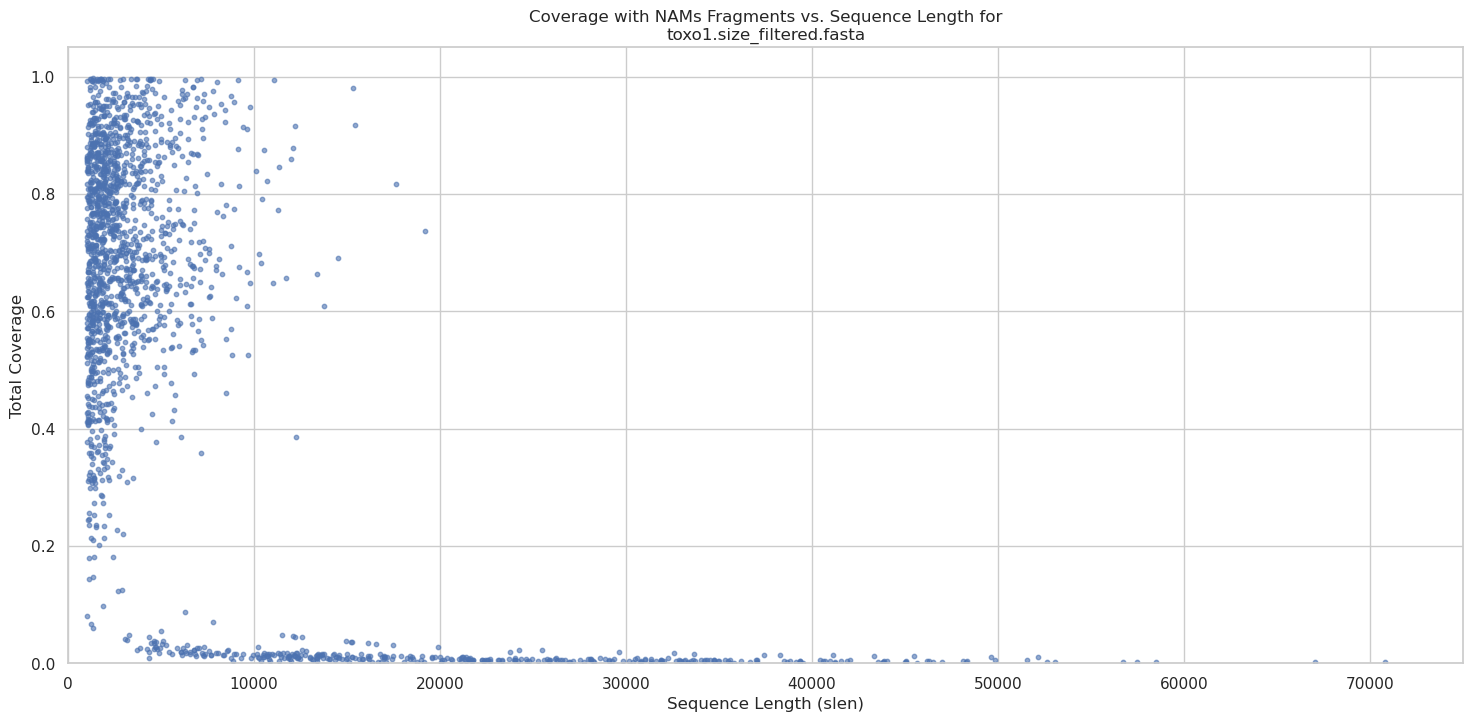

BLAST database created at: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/blast_db
Running BLAST alignment...
BLAST results saved to: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/blast.blocks_x_subject.tsv


/tmp/ipykernel_2348643/585130760.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_s = sorted_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject')).reset_index(name='coverage_fraction')


Sequences without Namasivayam blocks saved in: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/non_nam/Non_nam.decont.fasta
Total number of sequences: 12567
Number of NAM sequences: 631
Proportion of NAM fragments: 0.05
Median size: 4149.0
Mean size: 7914.002649006623
Median coverage: 0.9873219868009726
Mean coverage: 0.8053892868035218


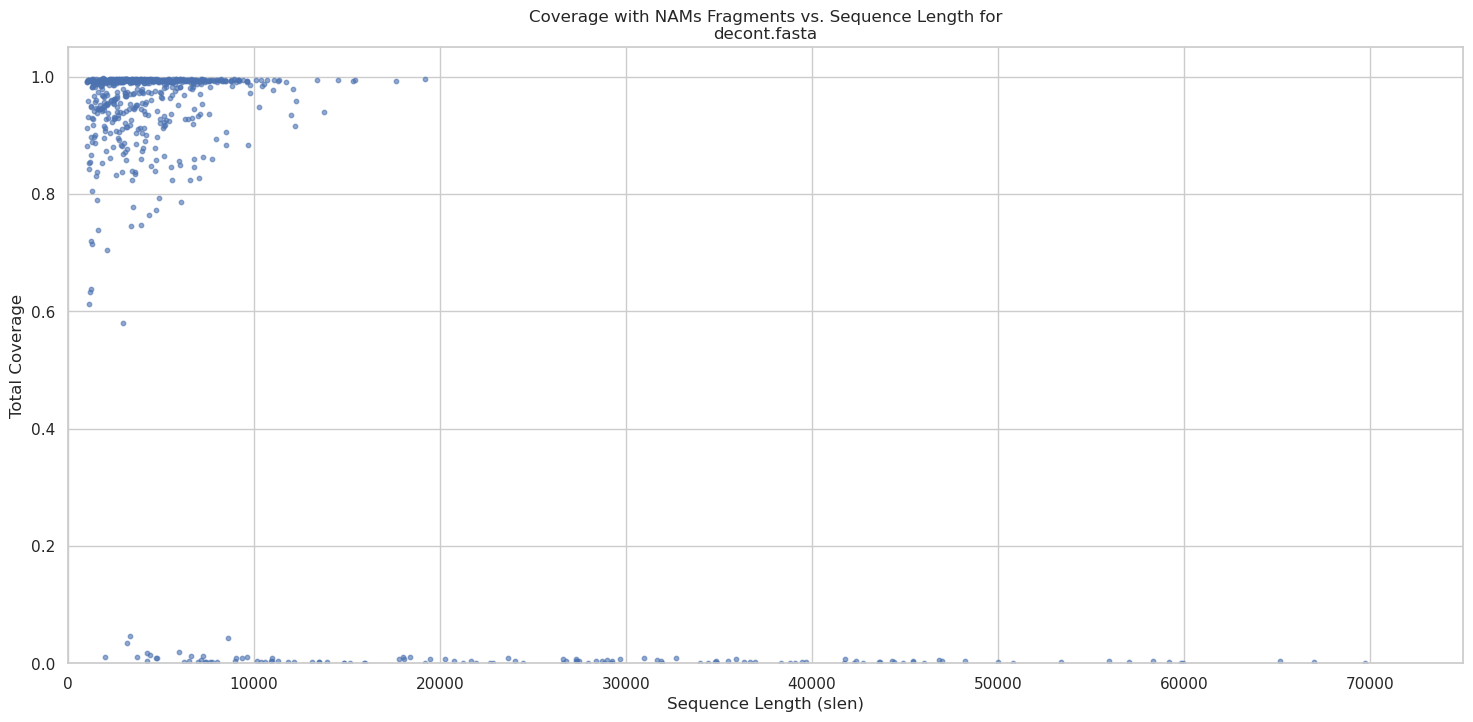

BLAST database created at: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/blast_db
Running BLAST alignment...
BLAST results saved to: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/blast.blocks_x_subject.tsv
Sequences without Namasivayam blocks saved in: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/non_nam/Non_nam.decont.low_gc.fasta
Total number of sequences: 1678
Number of NAM sequences: 631
Proportion of NAM fragments: 0.38
Median size: 3626.0
Mean size: 4291.679748822606
Median coverage: 0.9916765755053508
Mean coverage: 0.9539037257373596


/tmp/ipykernel_2348643/585130760.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_s = sorted_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject')).reset_index(name='coverage_fraction')


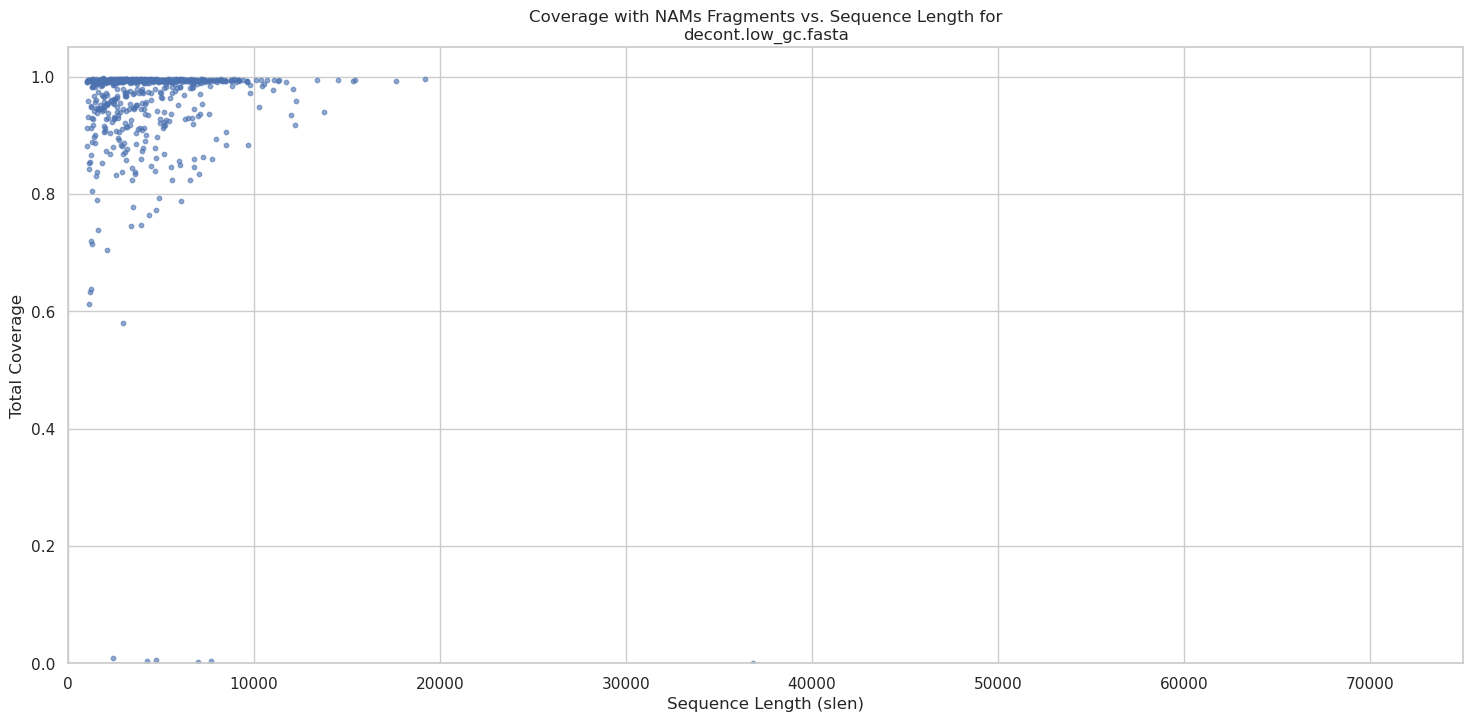

BLAST database created at: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/blast_db
Running BLAST alignment...
BLAST results saved to: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/blast.blocks_x_subject.tsv
Sequences without Namasivayam blocks saved in: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/non_nam/Non_nam.sequences_wo_str.fasta
Total number of sequences: 910
Number of NAM sequences: 625
Proportion of NAM fragments: 0.69
Median size: 3600.0
Mean size: 4229.528571428571
Median coverage: 0.992042216358839
Mean coverage: 0.9578205574680869


/tmp/ipykernel_2348643/585130760.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_s = sorted_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject')).reset_index(name='coverage_fraction')


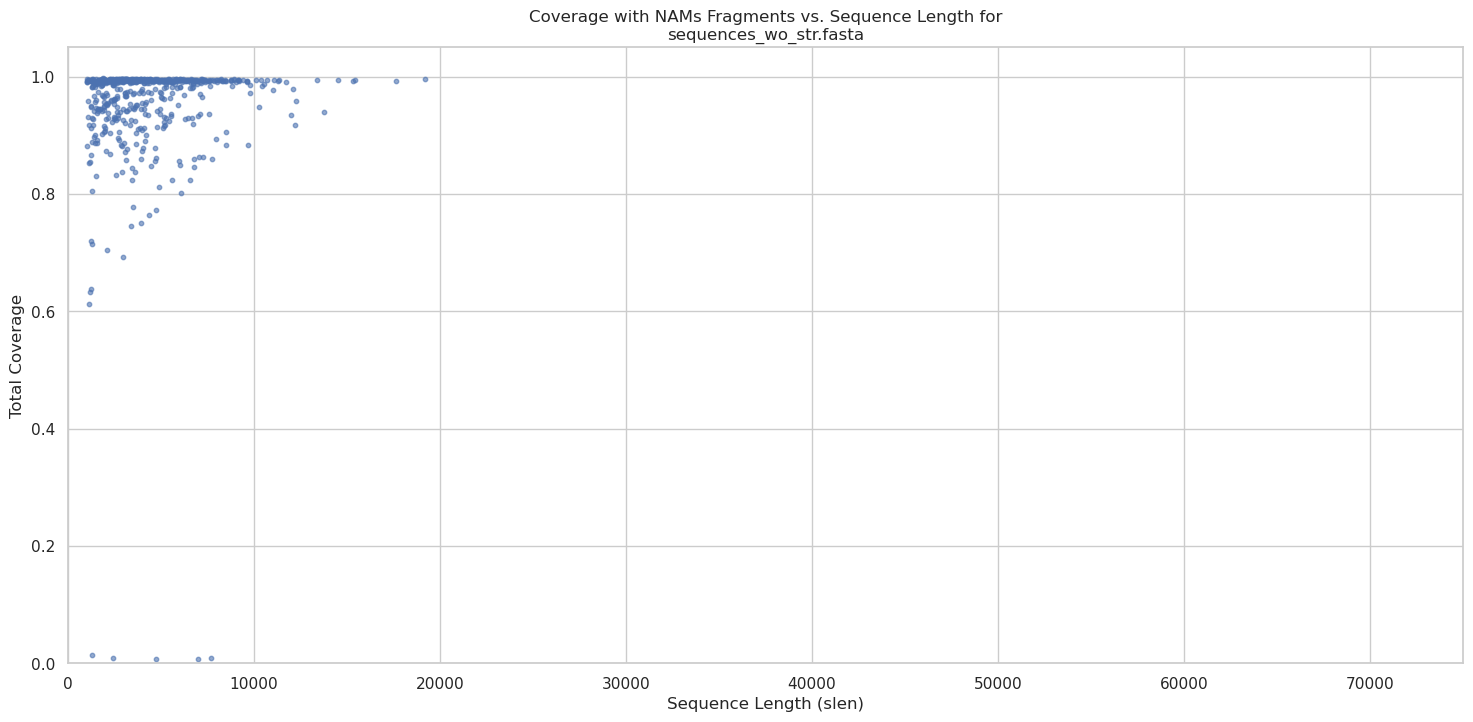

BLAST database created at: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/blast_db
Running BLAST alignment...
BLAST results saved to: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/blast.blocks_x_subject.tsv
Sequences without Namasivayam blocks saved in: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/non_nam/Non_nam.cluster_1.fasta
Total number of sequences: 625
Number of NAM sequences: 625
Proportion of NAM fragments: 1.00
Median size: 3599.0
Mean size: 4226.3664
Median coverage: 0.992
Mean coverage: 0.9651937622486861


/tmp/ipykernel_2348643/585130760.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_s = sorted_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject')).reset_index(name='coverage_fraction')


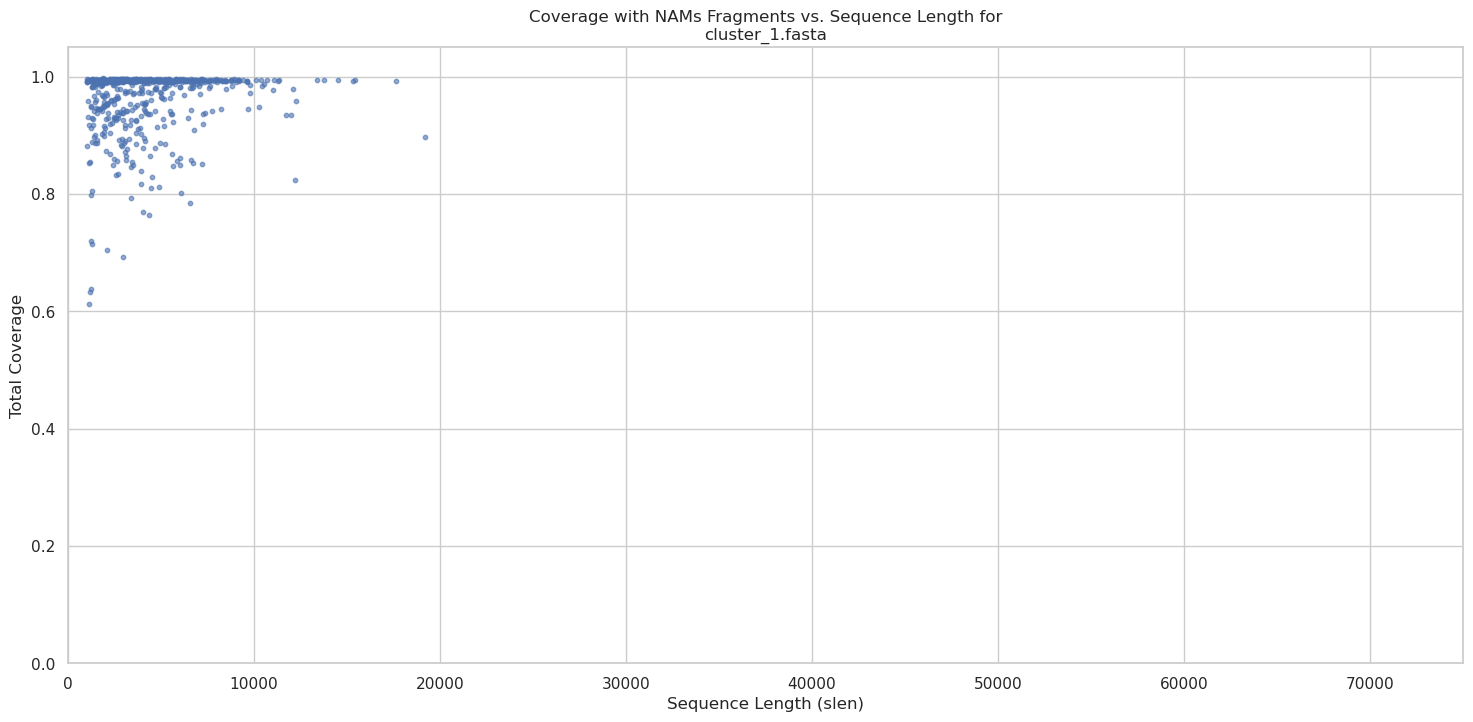

In [16]:
test = True
if test:
    print("Developer mode activated!")
    input_sequence_blocks = '/home/jpereira/OEs/Blocks_Namasivayam_without_p.fa'
    #input_subject_sequences = '/home/jpereira/OEs/OE1.v2/Data/decontamination/decont.fasta'
    #input_subject_sequences = '/home/jpereira/OEs/OE1.v2/Data/filter_sizes/toxo1.size_filtered.fasta'
    #input_subject_sequences = '/home/jpereira/OEs/OE1.v2/Data/check_gc/decont.low_gc.fasta'
    input_subject_sequences = '/home/jpereira/OEs/OE1.v2/Data/short_tandem_repeats/str_filtered.fasta'
    input_subject_sequences = '/home/jpereira/OEs/OE1.v2/Data/short_tandem_repeats/sequences_wo_str.fasta'
    input_subject_sequences = '/home/jpereira/OEs/OE1.v2/Data/check_gc/decont.high_gc.fasta'
    input_subject_sequences = '/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/mcl_clustering/sequneces_clusters/cluster_1.fasta'
    output_continuos_coverage_tsv = '/home/jpereira/OEs/OE1.v2/Data/continuos_coverage/continous_block_coverage.tsv'
    output_continuos_coverage_tsv = '/home/jpereira/OEs/OE1.v2/Data/continuos_coverage/continuos_block_coverage_sequences_clusters.tsv'
    params_threads = 30
    params_word_size = 10
else:
    parser = argparse.ArgumentParser(description='Analyze sequence block coverage')
    parser.add_argument('--input-sequence-blocks', type=str, help='Path to a FASTA file containing the rearranging sequence blocks')
    parser.add_argument('--input-subject-sequences', type=str, help='Path to a FASTA file containing the query sequences')
    parser.add_argument('--output-continuos-coverage-tsv', type=str, help='Path to output table with the continuos block coverage in the query sequences')
    parser.add_argument('--params-threads', type=int, help='Number of threads to use when performing blastn')
    parser.add_argument('--params-word-size', type=int, help='Blastn word size')
    args = parser.parse_args()
    
    input_sequence_blocks = args.input_sequence_blocks
    input_subject_sequences = args.input_subject_sequences
    output_continuos_coverage_tsv = args.output_continuos_coverage_tsv
    params_threads = args.params_threads
    params_word_size = args.params_word_size
    
print("Developer mode activated!")
input_sequence_blocks = '/home/jpereira/OEs/Blocks_Namasivayam_without_p.fa'
input_subject_sequences1 = '/home/jpereira/OEs/OE1.v2/Data/filter_sizes/toxo1.size_filtered.fasta'
input_subject_sequences2 = '/home/jpereira/OEs/OE1.v2/Data/decontamination/decont.fasta'
input_subject_sequences3 = '/home/jpereira/OEs/OE1.v2/Data/check_gc/decont.low_gc.fasta'
input_subject_sequences4 = '/home/jpereira/OEs/OE1.v2/Data/short_tandem_repeats/sequences_wo_str.fasta'
input_subject_sequences5 = '/home/jpereira/OEs/OE1.v2/Data/check_gc/decont.high_gc.fasta'
input_subject_sequences6 = '/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/mcl_clustering/sequneces_clusters/cluster_1.fasta'
input_subject_sequences7 = '/home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads.fasta'
output_non_nam_seqs_dir  = '/home/jpereira/OEs/OE1.v2/Data/continuos_coverage/non_nam/'
output_continuos_coverage_tsv = '/home/jpereira/OEs/OE1.v2/Data/continuos_coverage/continous_block_coverage.tsv'
params_threads = 30
params_word_size = 10

input_ss_lis = [input_subject_sequences1,
                input_subject_sequences2,
                input_subject_sequences3,
                input_subject_sequences4,
                #input_subject_sequences5,
                input_subject_sequences6]
                #input_subject_sequences7]

blast_df_list = []
nam_sequences_list = []
total_sequences_list = []
for input_subject_sequences in input_ss_lis:
    blast_df, nam_sequences, total_sequences = function_body(input_sequence_blocks=input_sequence_blocks,
                  input_subject_sequences=input_subject_sequences,
                  output_continuos_coverage_tsv=output_continuos_coverage_tsv,
                  output_non_nam_seqs_dir=output_non_nam_seqs_dir,
                  params_threads=params_threads,
                  params_word_size=params_word_size)
    
    blast_df_list.append(blast_df)
    total_sequences_list.append(total_sequences)
    nam_sequences_list.append(nam_sequences)
    



BLAST database created at: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/blast_db
Running BLAST alignment...
BLAST results saved to: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/blast.blocks_x_subject.tsv


/tmp/ipykernel_2348643/585130760.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_s = sorted_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject')).reset_index(name='coverage_fraction')


Sequences without Namasivayam blocks saved in: /home/jpereira/OEs/OE1.v2/Data/continuos_coverage/non_nam/Non_nam.decont.low_gc.fasta
Total number of sequences: 211
Number of NAM sequences: 211
Proportion of NAM fragments: 1.00
Median size: 1916.0
Mean size: 3008.2417061611372
Median coverage: 0.9804627249357326
Mean coverage: 0.956353796889295


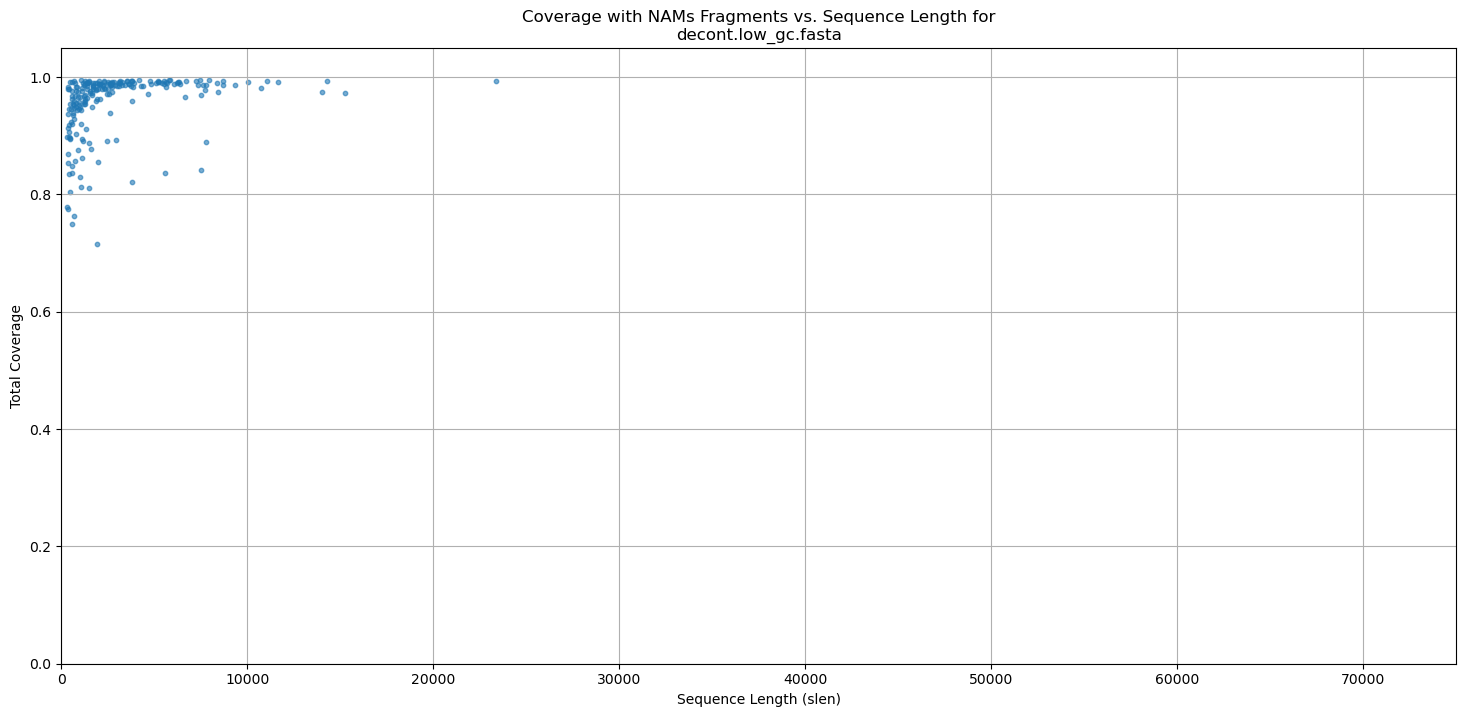

(          qseqid                                sseqid   pident  length  \
 0     Tg_mtDNA_A  fc2f9aaf-fef5-4d97-aef4-dd91dc3e343f  100.000     196   
 1     Tg_mtDNA_A  fc2f9aaf-fef5-4d97-aef4-dd91dc3e343f  100.000      13   
 2     Tg_mtDNA_A  f81653f6-d4c2-412d-b029-347e960375d8  100.000     196   
 3     Tg_mtDNA_A  f81653f6-d4c2-412d-b029-347e960375d8   99.490     196   
 4     Tg_mtDNA_A  f3772ab8-ad3c-4a45-90f4-41f8baf081ca  100.000     196   
 ...          ...                                   ...      ...     ...   
 4520  Tg_mtDNA_V  2798d827-74cc-4daf-ae9a-72d60d251ce4   93.333      15   
 4521  Tg_mtDNA_V  828f6cc9-f9e8-4211-b6f0-9a4de79357f8   93.333      15   
 4522  Tg_mtDNA_V  045e8846-7b26-4032-8f7c-401aeb809523   93.333      15   
 4523  Tg_mtDNA_V  045e8846-7b26-4032-8f7c-401aeb809523   93.333      15   
 4524  Tg_mtDNA_V  045e8846-7b26-4032-8f7c-401aeb809523   93.333      15   
 
       mismatch  gapopen  qstart  qend  sstart  send         evalue  bitscore  \
 0   

In [5]:
input_subject_sequences7 = '/home/jpereira/OEs/Results/OE1/NamSeqs/Data/check_gc/decont.low_gc.fasta' #/Data/mcl_clustering/sequneces_clusters/cluster_1.fasta'
output_non_nam_seqs_dir  = '/home/jpereira/OEs/OE1.v2/Data/continuos_coverage/non_nam/'
output_continuos_coverage_tsv = '/home/jpereira/OEs/OE1.v2/Data/continuos_coverage/continous_block_coverage.nam_seqs.tsv'
params_threads = 30
params_word_size = 10



function_body(input_sequence_blocks=input_sequence_blocks,
                input_subject_sequences=input_subject_sequences7,
                output_continuos_coverage_tsv=output_continuos_coverage_tsv,
                output_non_nam_seqs_dir=output_non_nam_seqs_dir,
                params_threads=params_threads,
                params_word_size=params_word_size,
                )
    

/tmp/ipykernel_2348643/2408457986.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  blast_covs = df.groupby('sseqid').apply(
/tmp/ipykernel_2348643/2408457986.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  blast_covs = df.groupby('sseqid').apply(
/tmp/ipykernel_2348643/2408457986.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in 

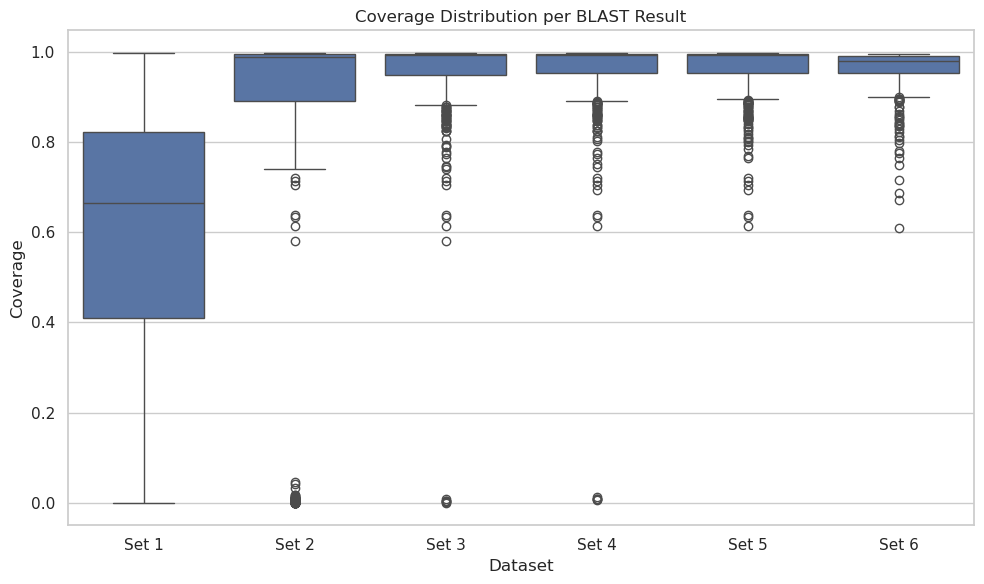

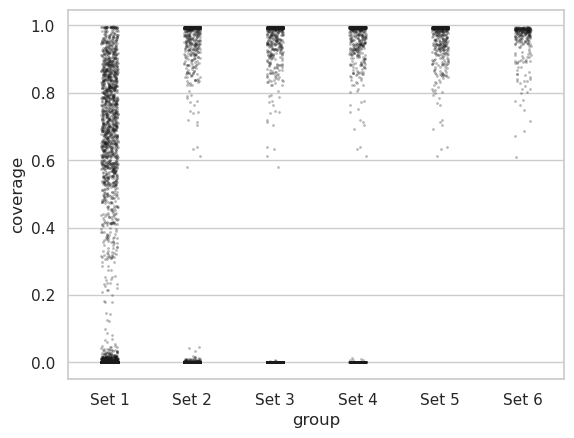

In [6]:
from blast_utils import alignment_absolute_start_end, total_coverage
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid')

blast_covs_list = []

# Loop through each BLAST dataframe
for df, total, nam in zip(blast_df_list, total_sequences_list, nam_sequences_list):
    df = alignment_absolute_start_end(df)
    blast_covs = df.groupby('sseqid').apply(
        lambda x: total_coverage(x.sort_values('a.sstart'), use='subject')
    ).reset_index(drop=True)

    zero_values = np.zeros(total - nam)
    blast_covs_full = pd.concat([blast_covs, pd.Series(zero_values)], ignore_index=True)

    blast_covs_list.append(blast_covs_full)

# Combine into one long-form DataFrame for Seaborn
plot_data = pd.DataFrame({
    'coverage': [cov for sublist in blast_covs_list for cov in sublist],
    'group': [f"Set {i+1}" for i, sublist in enumerate(blast_covs_list) for _ in sublist]
})

# Plot
plt.figure(figsize=(10, 6))
#sns.violinplot(x='group', y='coverage', data=plot_data[plot_data['coverage'] != 0],cut=0, inner=None, bw=0.1, scale='width', linewidth=1)
sns.boxplot(x='group', y='coverage', data=plot_data[plot_data['coverage'] != 0])
plt.ylabel('Coverage')
plt.xlabel('Dataset')
plt.title('Coverage Distribution per BLAST Result')
plt.tight_layout()
plt.show()

#sns.violinplot(..., inner=None)
sns.stripplot(x='group', y='coverage', data=plot_data, color='k', alpha=0.3, size=2, jitter=True)
plt.show()


In [60]:
A= [1,2,3,4]
np.array(['a',2])

array(['a', '2'], dtype='<U21')

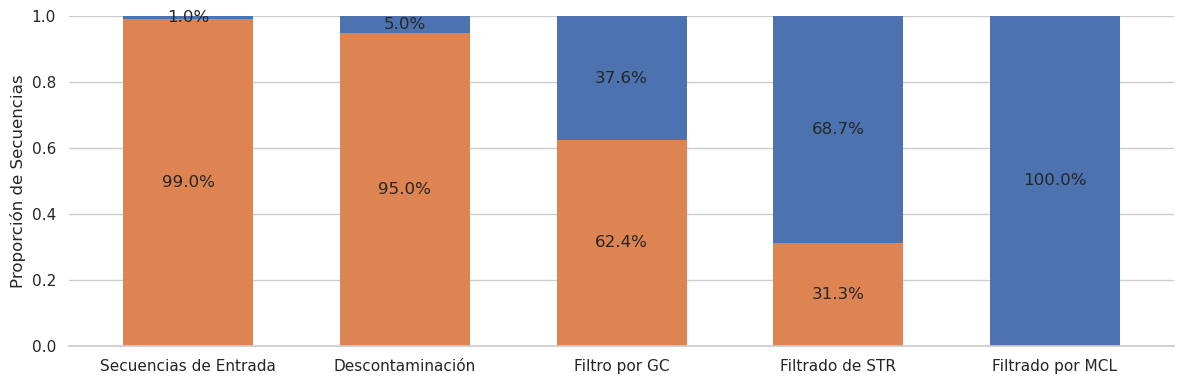

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
#sns.set_context("talk")  # slightly larger fonts

# 1. Compute zero vs non-zero counts
zeros    = [tot - nam for tot, nam in zip(total_sequences_list, nam_sequences_list)]
nonzeros = nam_sequences_list
labels   = ['Secuencias de Entrada', 'Descontaminación', 'Filtro por GC','Filtrado de STR', 'Filtrado por MCL'] #, 'Nam_Seqs'] 
colors = np.array(sns.color_palette("deep"))[[1,0]]

counts_df = pd.DataFrame({
    'Zero coverage':     zeros,
    'Non-zero coverage': nonzeros
}, index=labels)

# 2. Convert to proportions
prop_df = counts_df.div(counts_df.sum(axis=1), axis=0)

# 3. Plot
plt.figure(figsize=(12, 4))
ax = prop_df.plot(
    kind='bar',
    stacked=True,
    color=colors,   # use a seaborn palette
    edgecolor='none',
    width=0.6,
    legend=False,                         # turn legend back on
    ax=plt.gca(),
)

# Add percentage labels
for container in ax.containers:
    bar_labels = [f'{w:.1%}' if w != 0 else '' for w in container.datavalues]
    ax.bar_label(container, labels=bar_labels, label_type='center', fontsize=12)


# 4. Labels, title, ticks
ax.set_ylabel('Proporción de Secuencias')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.set_xticklabels(labels, rotation=0)

# 5. Clean up spines
sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.show()


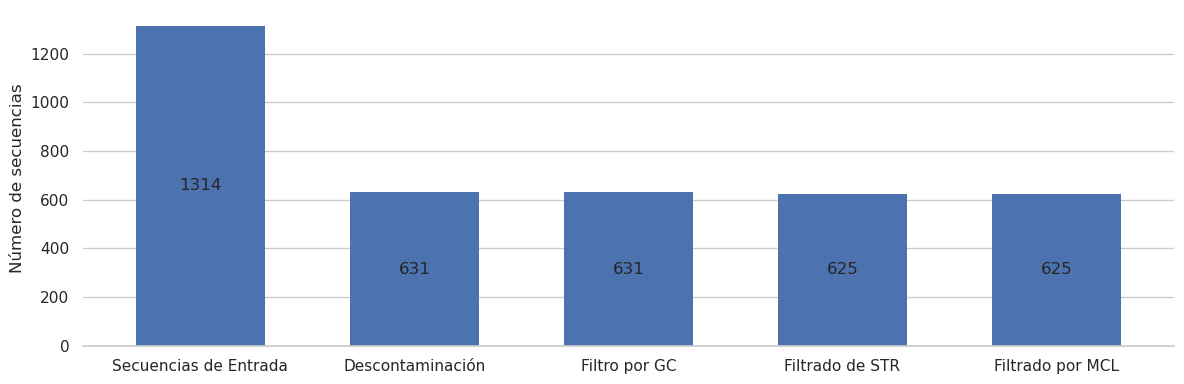

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plot_df = pd.DataFrame({ 'Total Sequences' : nam_sequences_list, 'Step': ['A', 'B', 'C', 'D', 'E']  })


# 3. Plot
plt.figure(figsize=(12, 4))

ax = plot_df.plot(
    kind='bar',
    stacked=True,
    color=sns.color_palette("deep")[0],   # use a seaborn palette
    edgecolor='none',
    width=0.6,
    legend=False,                         # turn legend back on
    ax=plt.gca(),
)
#

# Add percentage labels
for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(w)}' for w in container.datavalues], label_type='center', fontsize=12)


# 4. Labels, title, ticks
ax.set_ylabel('Número de secuencias')
ax.set_xlabel('')
#ax.set_ylim(0, 1)
ax.set_xticklabels(labels, rotation=0)
ax.grid(axis='x')

# 5. Clean up spines
sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.show()

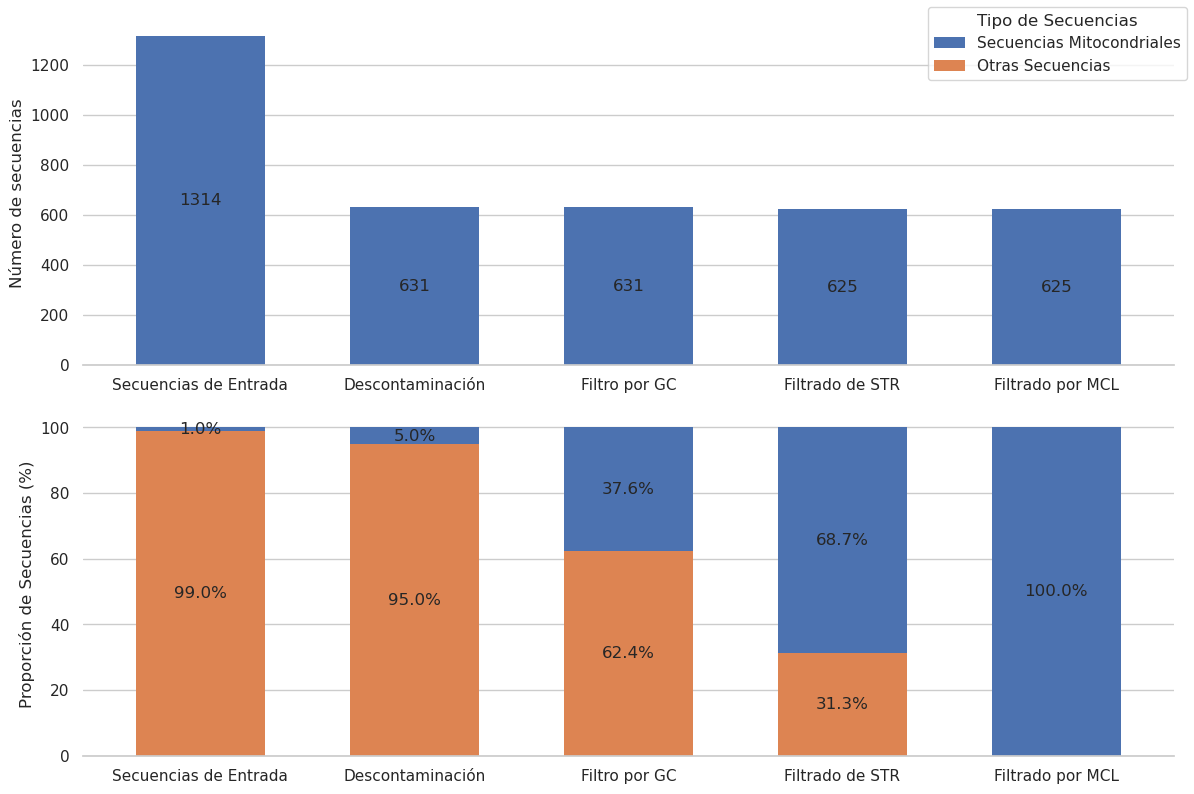

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

save_dir = Path("/home/jpereira/OEs/Congresos/SUB_2025")
save_dir.mkdir(exist_ok=True, parents=True)

sns.set_theme(style='whitegrid')

# — Example data (replace with your real lists) —
zeros    = [tot - nam for tot, nam in zip(total_sequences_list, nam_sequences_list)]
nonzeros = nam_sequences_list
labels1  = ['Secuencias de Entrada', 'Descontaminación', 'Filtro por GC',
            'Filtrado de STR', 'Filtrado por MCL']
colors   = np.array(sns.color_palette("deep"))[[1, 0]]

counts_df = pd.DataFrame({
    'Zero coverage':     zeros,
    'Non-zero coverage': nonzeros
}, index=labels1)
prop_df = counts_df.div(counts_df.sum(axis=1), axis=0) * 100

plot_df = pd.DataFrame({
    'Total Sequences': nam_sequences_list,
    'Step': labels1
})

# — Create a single figure with 2 subplots —
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(12, 8))

# == Left: Stacked‐bar proportion plot ==
prop_df.plot(
    kind='bar',
    stacked=True,
    color=colors,
    edgecolor='none',
    width=0.6,
    legend=False,
    ax=ax1
)
for cont in ax1.containers:
    new_cont = cont
    labels = [f'{w/100:.1%}' if w != 0 else '' for w in cont.datavalues]
    ax1.bar_label(cont, labels=labels, label_type='center', fontsize=12)

ax1.set_ylabel('Proporción de Secuencias (%)')
ax1.set_xticklabels(labels1, rotation=0)
ax1.grid(axis='x')
sns.despine(ax=ax1, left=True, bottom=False)

# == Right: Simple bar plot of totals ==
plot_df.plot(
    kind='bar',
    x='Step',
    y='Total Sequences',
    color=sns.color_palette("deep")[0],
    edgecolor='none',
    width=0.6,
    legend=False,
    ax=ax2
)
for cont in ax2.containers:
    ax2.bar_label(cont, labels=[f'{int(v)}' for v in cont.datavalues],
                  label_type='center', fontsize=12)

ax2.set_ylabel('Número de secuencias')
ax2.set_xlabel('')
ax2.set_xticklabels(plot_df['Step'], rotation=0)
ax2.grid(axis='x')
handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles[::-1],  # reverse the order of the colored boxes
    ['Secuencias Mitocondriales', 'Otras Secuencias'],  # reversed labels
    title='Tipo de Secuencias',
    loc='upper right'
)
#fig.legend(labels=['Otras Secuencias','Secuencias Mitocondriales'], title='Tipo de Secuencias')
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


sns.despine(ax=ax2, left=True, bottom=False)


plt.tight_layout()
plt.savefig(save_dir / 'decontamination_barplots_2.svg')
plt.show()
plt.close()

In [99]:
handles[0][1]

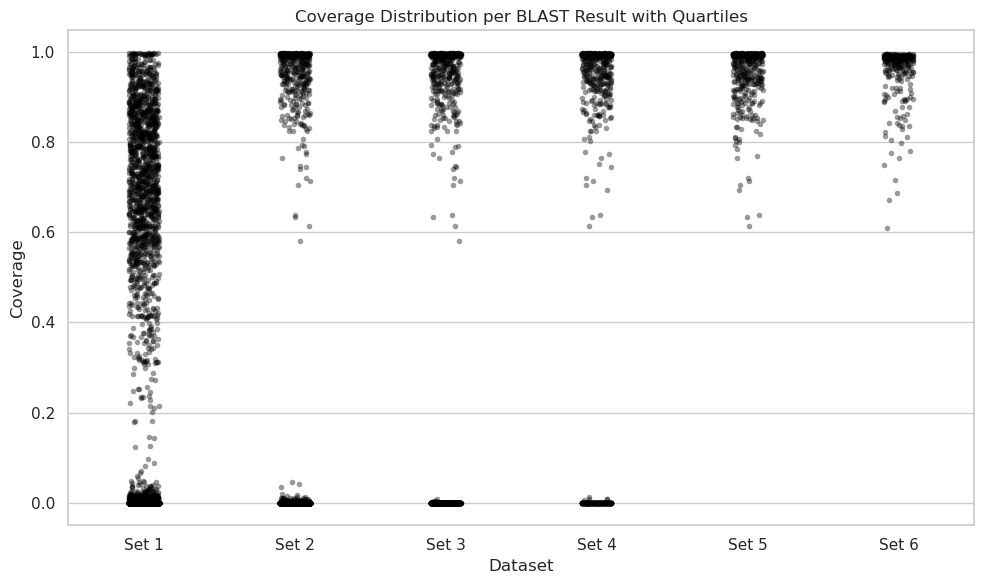

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create your strip plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(x='group', y='coverage', data=plot_data, color='black',jitter=True, alpha=0.4, size=4)

# Compute and add quartiles manually
#for i, group in enumerate(plot_data['group'].unique()):
#    group_data = plot_data[plot_data['group'] == group]['coverage']
#    q1, q2, q3 = np.percentile(group_data, [25, 50, 75])
#    
#    # Draw horizontal lines for quartiles at the x position of the category
#    for q in [q1, q2, q3]:
#        ax.hlines(y=q, xmin=i - 0.2, xmax=i + 0.2, colors='black', linewidth=2)

# Style
plt.ylabel('Coverage')
plt.xlabel('Dataset')
plt.title('Coverage Distribution per BLAST Result with Quartiles')
plt.tight_layout()
plt.show()


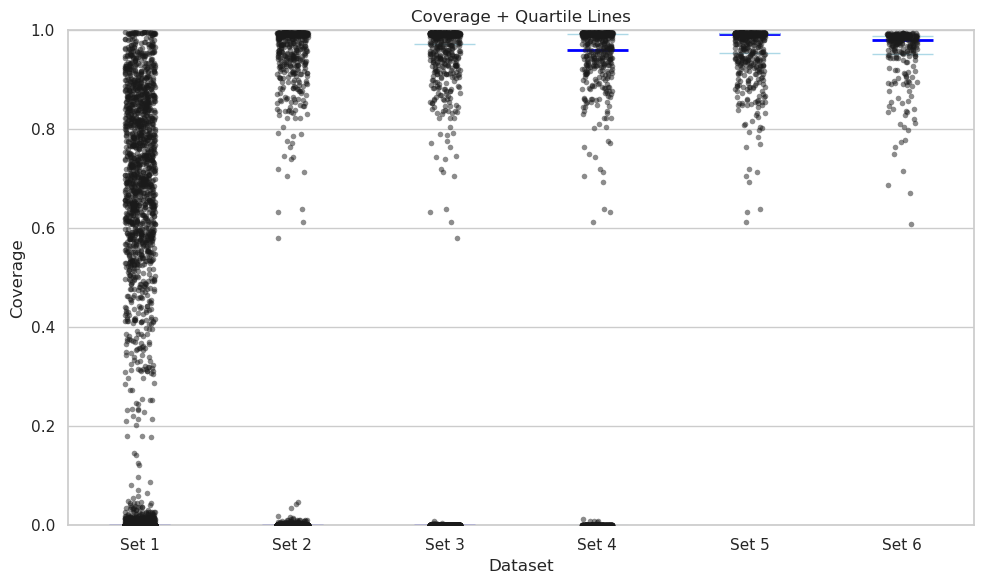

In [11]:
import numpy as np

# 1. Plot stripplot
plt.figure(figsize=(10,6))
sns.stripplot(
    x='group', y='coverage',color='k', data=plot_data,
    jitter=True,  alpha=0.5, size=4
)

# 2. Compute quartiles per group
qs = plot_data.groupby('group')['coverage'].quantile([0.25,0.5,0.75])\
              .unstack(level=-1)  # DataFrame with cols [0.25, 0.5, 0.75]

# 3. Draw horizontal lines at each quartile
for i, (_, row) in enumerate(qs.iterrows()):
    for q in [0.25, 0.5, 0.75]:
        plt.hlines(
            y=row[q],
            xmin=i - 0.2, xmax=i + 0.2,
            color='blue' if q==0.5 else 'lightblue',
            linewidth=2 if q==0.5 else 1
        )

plt.ylabel('Coverage')
plt.xlabel('Dataset')
plt.title('Coverage + Quartile Lines')
plt.ylim(0,1)
plt.tight_layout()
plt.show()



/tmp/ipykernel_1545569/409626083.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: total_coverage(x.sort_values('a.sstart'), use='subject'))
/tmp/ipykernel_1545569/409626083.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: total_coverage(x.sort_values('a.sstart'), use='subject'))


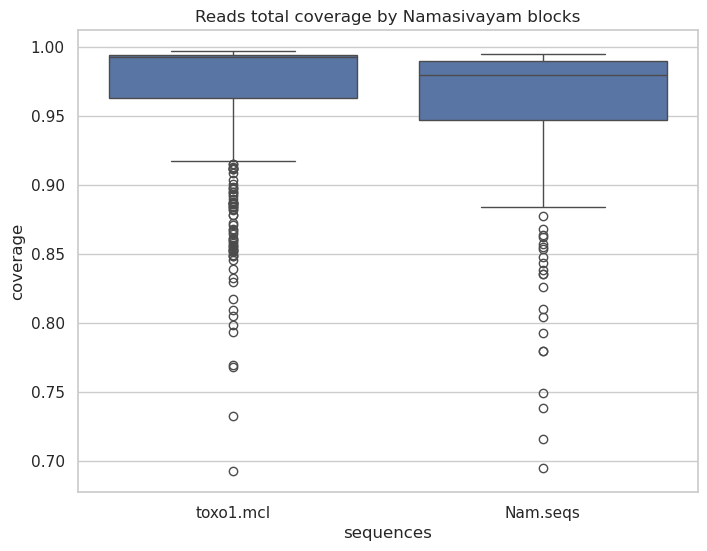

In [ ]:
from blast_utils import alignment_absolute_start_end, total_coverage
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and rename columns
nam_blast_path = '/home/jpereira/OEs/OE1.v2/Data/continuos_coverage/continous_block_coverage.nam_blocks.tsv'
mcl_filtered_path = '/home/jpereira/OEs/OE1.v2/Data/continuos_coverage/continous_block_coverage.tsv'
nam_df = pd.read_csv(nam_blast_path, sep='\t')
mcl_df = pd.read_csv(mcl_filtered_path, sep='\t')

blast_columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen',
                 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'slen', 'qlen']
nam_df.columns = blast_columns
mcl_df.columns = blast_columns

# Calculate absolute coordinates
nam_df = alignment_absolute_start_end(nam_df)
mcl_df = alignment_absolute_start_end(mcl_df)

# Apply total_coverage function grouped by 'sseqid', sorting each group by 'a.sstart'
nam_covs = (
    nam_df
    .groupby('sseqid')
    .apply(lambda x: total_coverage(x.sort_values('a.sstart'), use='subject'))
)

mcl_covs = (
    mcl_df
    .groupby('sseqid')
    .apply(lambda x: total_coverage(x.sort_values('a.sstart'), use='subject'))
)


covs = pd.concat([mcl_covs, nam_covs])
labels = ['toxo1.mcl'] * len(mcl_covs) + ['Nam.seqs'] * len(nam_covs)

plt.figure(figsize=(8,6))
sns.set_theme(style='whitegrid')
df = pd.DataFrame(  {'coverage' : covs, 'sequences' : labels } )
sns.boxplot(y='coverage', x='sequences', data=df) 
plt.title('Reads total coverage by Namasivayam blocks')
plt.show()

### LOW GC DECONT FASTA

In [ ]:
# Include sequences that doesn't have any alignments
# -Load Decont sequences,
# -Check differences between sseqid set from blast alignments and the sequences set
# -Add the missing sequences to the plot_df, (plot_df.columns: sseqid, slen, total_coverage)
# -The value of then newly added sequences should be [sseqid, slen, 0]

In [ ]:
# Decont fasta
# El bloque P mapea en la secuencia '00ccef4f-a50e-4fd6-8647-43b8cfbfc588' si se usa el archivo sin contaminar
seq588_df = alignment_absolute_start_end(blast_results_df[blast_results_df['sseqid'] == '00ccef4f-a50e-4fd6-8647-43b8cfbfc588'])
seq588_df = seq588_df.sort_values(['sseqid', 'a.sstart', 'a.send'])
total_coverage = seq588_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject')).reset_index(name='coverage_fraction')
print(total_coverage)
seq588_df

                                 sseqid  coverage_fraction
0  00ccef4f-a50e-4fd6-8647-43b8cfbfc588            0.99568


/tmp/ipykernel_1686427/1084023430.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage = seq588_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject')).reset_index(name='coverage_fraction')


,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,slen,qlen,a.sstart,a.send,dir
268,Tg_mtDNA_A,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,100.000,99,0,0,1,99,100,2,4.710000e-46,183.0,3935,196,2,100,R
3040,Tg_mtDNA_E,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,97.518,685,3,10,1,683,773,101,0.000000e+00,1158.0,3935,683,101,773,R
5297,Tg_mtDNA_J,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,98.824,85,0,1,1,85,857,774,1.750000e-36,150.0,3935,85,774,857,R
9595,Tg_mtDNA_O,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,100.000,86,0,0,1,86,858,943,2.910000e-39,159.0,3935,86,858,943,F
3724,Tg_mtDNA_F,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,98.324,179,0,2,1,179,944,1119,1.870000e-84,311.0,3935,179,944,1119,F
8539,Tg_mtDNA_M,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,97.613,754,3,9,1,754,1858,1120,0.000000e+00,1279.0,3935,754,1120,1858,R
1132,Tg_mtDNA_B,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,100.000,40,0,0,1,40,1898,1859,3.270000e-14,75.0,3935,40,1859,1898,R
5296,Tg_mtDNA_J,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,100.000,85,0,0,1,85,1983,1899,1.050000e-38,158.0,3935,85,1899,1983,R
9596,Tg_mtDNA_O,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,100.000,86,0,0,1,86,1984,2069,2.910000e-39,159.0,3935,86,1984,2069,F
6402,Tg_mtDNA_K,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,99.551,445,1,1,1,445,2513,2070,0.000000e+00,809.0,3935,445,2070,2513,R


In [ ]:
# Cont fasta
# El bloque P no se mapea en la secuencia '00ccef4f-a50e-4fd6-8647-43b8cfbfc588' si se usa el archivo contaminado
seq588_df = alignment_absolute_start_end(blast_results_df[blast_results_df['sseqid'] == '00ccef4f-a50e-4fd6-8647-43b8cfbfc588'])
seq588_df = seq588_df.sort_values(['sseqid', 'a.sstart', 'a.send'])
total_coverage = seq588_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject')).reset_index(name='coverage_fraction')
print(total_coverage)
seq588_df

                                 sseqid  coverage_fraction
0  00ccef4f-a50e-4fd6-8647-43b8cfbfc588           0.948412


/tmp/ipykernel_1686427/314380614.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage = seq588_df.groupby('sseqid').apply(lambda x: total_coverage(x, use='subject')).reset_index(name='coverage_fraction')


,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,slen,qlen,a.sstart,a.send,dir
412,Tg_mtDNA_A,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,100.000,99,0,0,1,99,100,2,1.150000e-44,183.0,3935,196,2,100,R
3423,Tg_mtDNA_E,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,97.518,685,3,10,1,683,773,101,0.000000e+00,1158.0,3935,683,101,773,R
6360,Tg_mtDNA_J,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,98.824,85,0,1,1,85,857,774,4.060000e-35,150.0,3935,85,774,857,R
10087,Tg_mtDNA_O,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,100.000,86,0,0,1,86,858,943,6.870000e-38,159.0,3935,86,858,943,F
4209,Tg_mtDNA_F,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,98.324,179,0,2,1,179,944,1119,4.540000e-83,311.0,3935,179,944,1119,F
8872,Tg_mtDNA_M,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,97.613,754,3,9,1,754,1858,1120,0.000000e+00,1279.0,3935,754,1120,1858,R
1189,Tg_mtDNA_B,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,100.000,40,0,0,1,40,1898,1859,6.400000e-13,75.0,3935,40,1859,1898,R
6359,Tg_mtDNA_J,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,100.000,85,0,0,1,85,1983,1899,2.430000e-37,158.0,3935,85,1899,1983,R
10088,Tg_mtDNA_O,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,100.000,86,0,0,1,86,1984,2069,6.870000e-38,159.0,3935,86,1984,2069,F
6784,Tg_mtDNA_K,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,99.551,445,1,1,1,445,2513,2070,0.000000e+00,809.0,3935,445,2070,2513,R


In [ ]:
# Decont fasta
plot_df[plot_df['coverage_fraction'] > 0.99]['sseqid'].head(10)

1        00ccef4f-a50e-4fd6-8647-43b8cfbfc588
17       010eb988-7c29-4f28-b3bf-dae64cf79c9d
52       01befc45-eaf0-4cb3-9de3-c50e0d744b6f
70       0266e194-fe82-4fa1-98d3-aebf9cfd7311
76       0291c6a1-d060-4427-9899-84e9f727b290
                         ...                 
13895    fdc06b88-94fa-47fd-bde5-b0b518aa0ad3
13957    fdd95ccd-3840-4be4-8620-309f01e8180e
13967    fe60679c-b844-49aa-a9c3-b977e13cbb3e
14017    fecde708-f08f-4851-83a0-4322f5b9c0d7
14037    fed7cda0-08f7-424b-9dcf-720f0821997c
Name: sseqid, Length: 348, dtype: object

In [47]:
# Cont fasta
plot_df[plot_df['coverage_fraction'] > 0.99]

,sseqid,coverage_fraction,slen
72,01befc45-eaf0-4cb3-9de3-c50e0d744b6f,0.995235,3358
102,02884229-d63b-4336-bbb8-986bc67f1dfb,0.994502,1637
277,058e861d-e914-4aca-ac1f-e3b5042c1c99,0.994995,4396
1049,0fcfb5a3-c448-4f33-a98c-0e65584be20b,0.994061,6903
1129,1138ae60-6b3d-4063-9716-85a1560cc428,0.993048,1870
1266,144b3cb6-dfeb-4cc0-b591-006197c8a6f0,0.995951,1729
1318,15ebdd61-7f50-4c41-aa19-6492c38ab198,0.995269,2959
1374,17e9522d-5e14-4165-9844-11550cb0a06d,0.993843,4385
1833,21efc012-a89a-4981-a5c4-356894a8fd5b,0.994078,9118
2056,2657a56a-f109-44e0-97bf-9b0272a2a97b,0.995836,1921


In [21]:
coverage_df[coverage_df['sseqid'] == '00ccef4f-a50e-4fd6-8647-43b8cfbfc588'].head(1)

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,slen,qlen,a.sstart,a.send,dir,coverage_fraction
1,Tg_mtDNA_A,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,100.0,99,0,0,1,99,100,2,4.710000e-46,183.0,3935,196,2,100,R,0.99568


In [23]:
coverage_df[coverage_df['sseqid'] == '00ccef4f-a50e-4fd6-8647-43b8cfbfc588'].head(1)

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,slen,qlen,a.sstart,a.send,dir,coverage_fraction
34,Tg_mtDNA_A,00ccef4f-a50e-4fd6-8647-43b8cfbfc588,100.0,99,0,0,1,99,100,2,1.150000e-44,183.0,3935,196,2,100,R,0.948412


### New decont results (70% matching bases filter, higher gap pennalty)

Hipótesis:
1. Las secuencias con una cobertura de bloques de namasivayam mayor al 95% claramente son read mitocondriales
2. Las secuencias con una cobertura de menor al 10% son secuencias contaminantes que no lograron ser filtradas
3. Las secuencias con una cobertura de intermedia pueden ser:
   -  Secuencias de T. gondii no reconocidas por la referencia,
   -  Secuencias mitocondriales con nuevos bloques
   -  Secuencias mitocondriales con bloques parciales que no lograron ser mapeados
   -  Blastn no siempre mapea todos los alineamientos en las bases grandes? (Abría que esta corroborrar que esta tendencia se repite para todos las secuencias)


Number of sequences: 685
Median size: 3897.0
Mean size: 6523.493430656934 
Median coverage: 0.990350250178699
Mean coverage: 0.8856828810872323


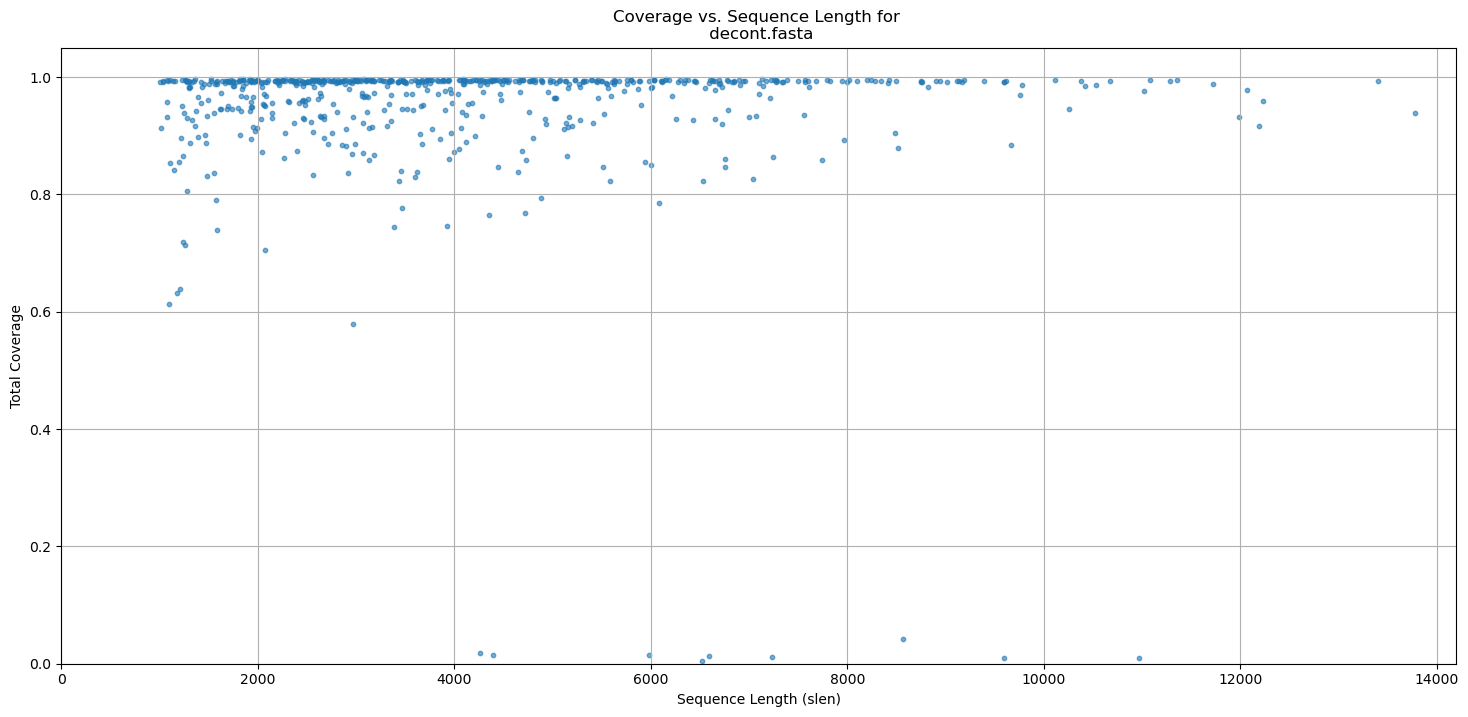

In [6]:
import matplotlib.pyplot as plt


print(f"Number of sequences: {plot_df.shape[0]}")
print(f"Median size: {plot_df['slen'].median()}")
print(f"Mean size: {plot_df['slen'].mean()} ")
print(f"Median coverage: {plot_df['coverage_fraction'].median()}")
print(f"Mean coverage: {plot_df['coverage_fraction'].mean()}")

plt.figure(figsize=(18, 8))
plt.scatter(plot_df['slen'], plot_df['coverage_fraction'], alpha=0.6, s=10)
plt.xlabel('Sequence Length (slen)')
plt.ylabel('Total Coverage')
plt.title(f'Coverage vs. Sequence Length for \n {os.path.basename(input_subject_sequences)}')
plt.xlim((0,14200))
plt.ylim((0,1.05))

plt.grid(True)

#plt.savefig(output_plot_path)
plt.show()

### Old decontamination (only 70% coverage filter)

Number of sequences: 630
Median size: 3620.5
Mean size: 4237.933333333333 
Median coverage: 0.8430753796430891
Mean coverage: 0.8178972517477598


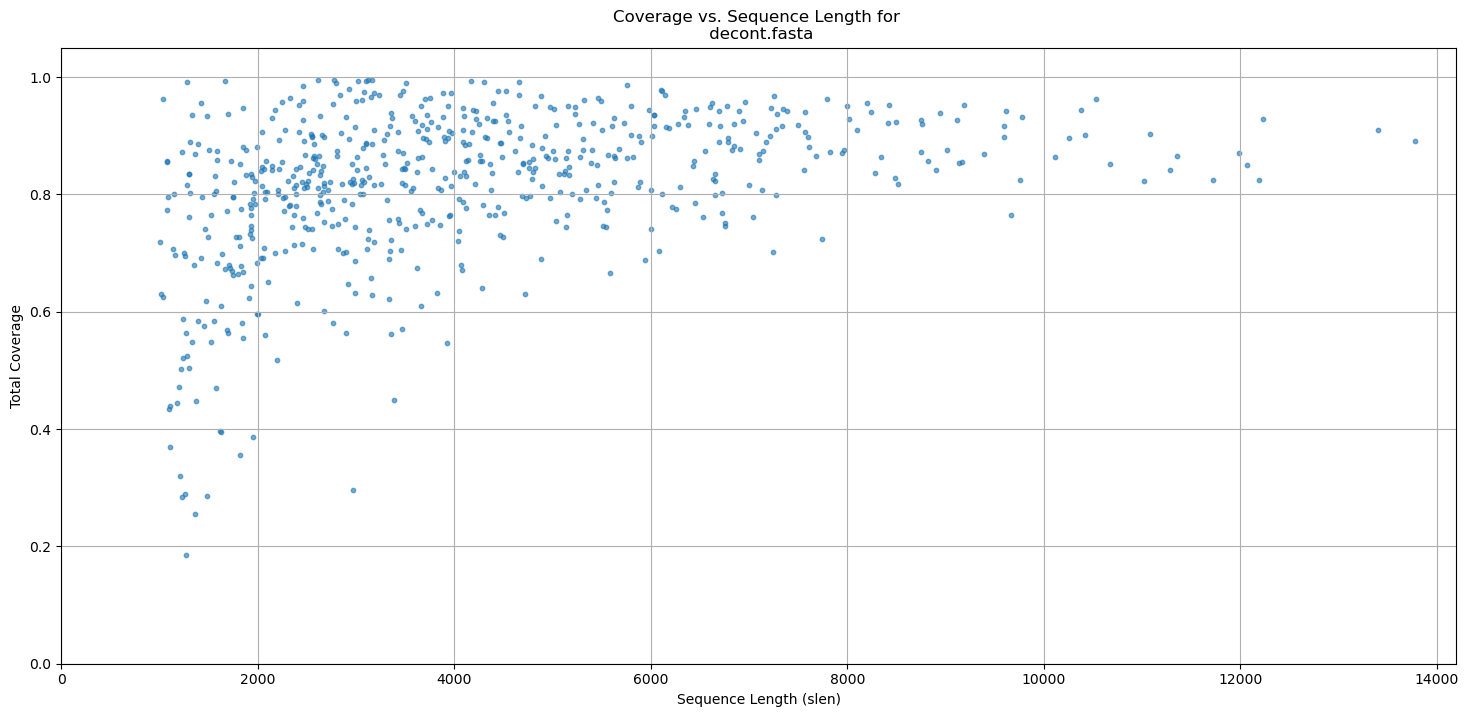

In [4]:
import matplotlib.pyplot as plt


print(f"Number of sequences: {plot_df.shape[0]}")
print(f"Median size: {plot_df['slen'].median()}")
print(f"Mean size: {plot_df['slen'].mean()} ")
print(f"Median coverage: {plot_df['coverage_fraction'].median()}")
print(f"Mean coverage: {plot_df['coverage_fraction'].mean()}")

plt.figure(figsize=(18, 8))
plt.scatter(plot_df['slen'], plot_df['coverage_fraction'], alpha=0.6, s=10)
plt.xlabel('Sequence Length (slen)')
plt.ylabel('Total Coverage')
plt.title(f'Coverage vs. Sequence Length for \n {os.path.basename(input_subject_sequences)}')
plt.xlim((0,14200))
plt.ylim((0,1.05))

plt.grid(True)

#plt.savefig(output_plot_path)
plt.show()

### Without decontamination 

Number of sequences: 1872
Median size: 2819.5
Mean size: 6818.372863247863 
Median coverage: 0.6640459370414058
Mean coverage: 0.5704692938987858


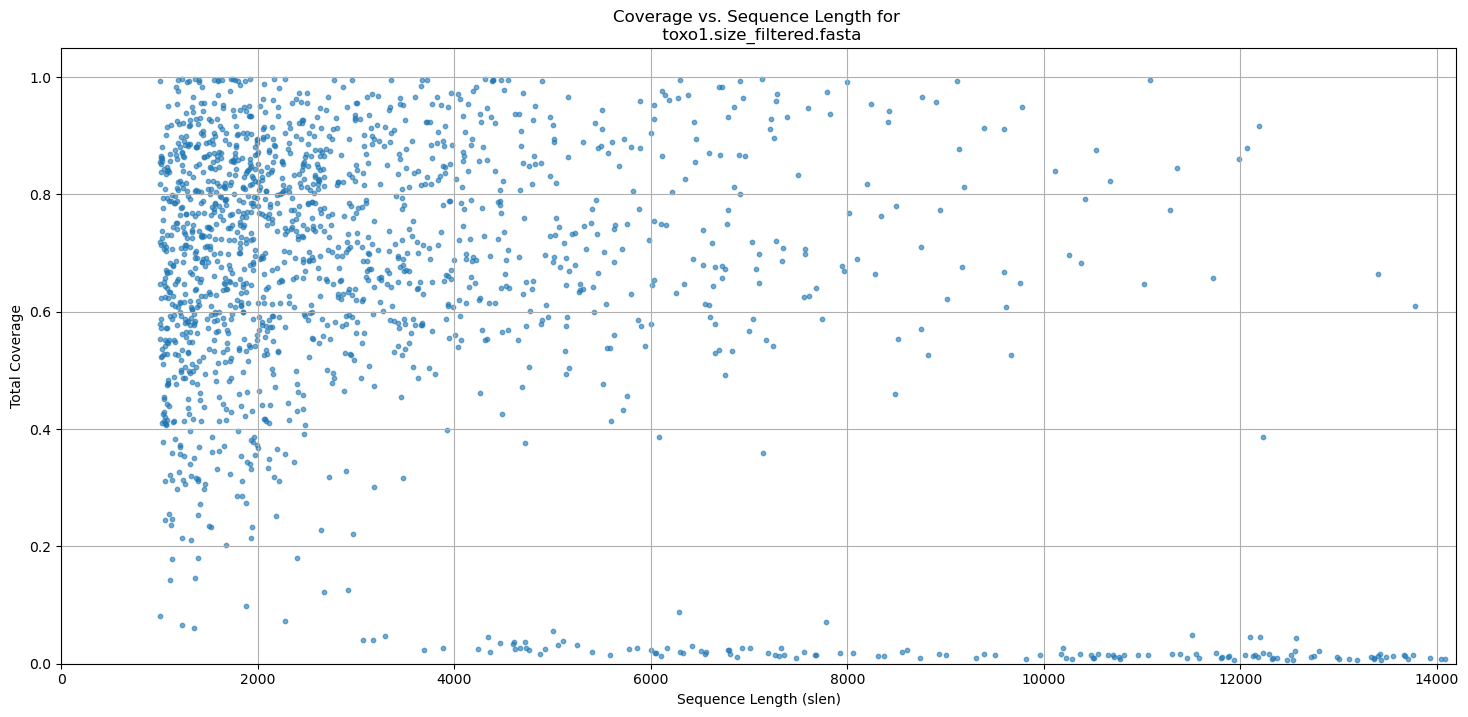

In [24]:
import matplotlib.pyplot as plt


print(f"Number of sequences: {plot_df.shape[0]}")
print(f"Median size: {plot_df['slen'].median()}")
print(f"Mean size: {plot_df['slen'].mean()} ")
print(f"Median coverage: {plot_df['coverage_fraction'].median()}")
print(f"Mean coverage: {plot_df['coverage_fraction'].mean()}")

plt.figure(figsize=(18, 8))
plt.scatter(plot_df['slen'], plot_df['coverage_fraction'], alpha=0.6, s=10)
plt.xlabel('Sequence Length (slen)')
plt.ylabel('Total Coverage')
plt.title(f'Coverage vs. Sequence Length for \n {os.path.basename(input_subject_sequences)}')
plt.xlim((0,14200))
plt.ylim((0,1.05))

plt.grid(True)

#plt.savefig(output_plot_path)
plt.show()

# Decontamined sequences Results (coverage 70%)

Number of sequences: 201
Median size: 2810.0
Mean size: 5268.44776119403 
Median coverage: 0.9927007299270073
Mean coverage: 0.9130756591485863


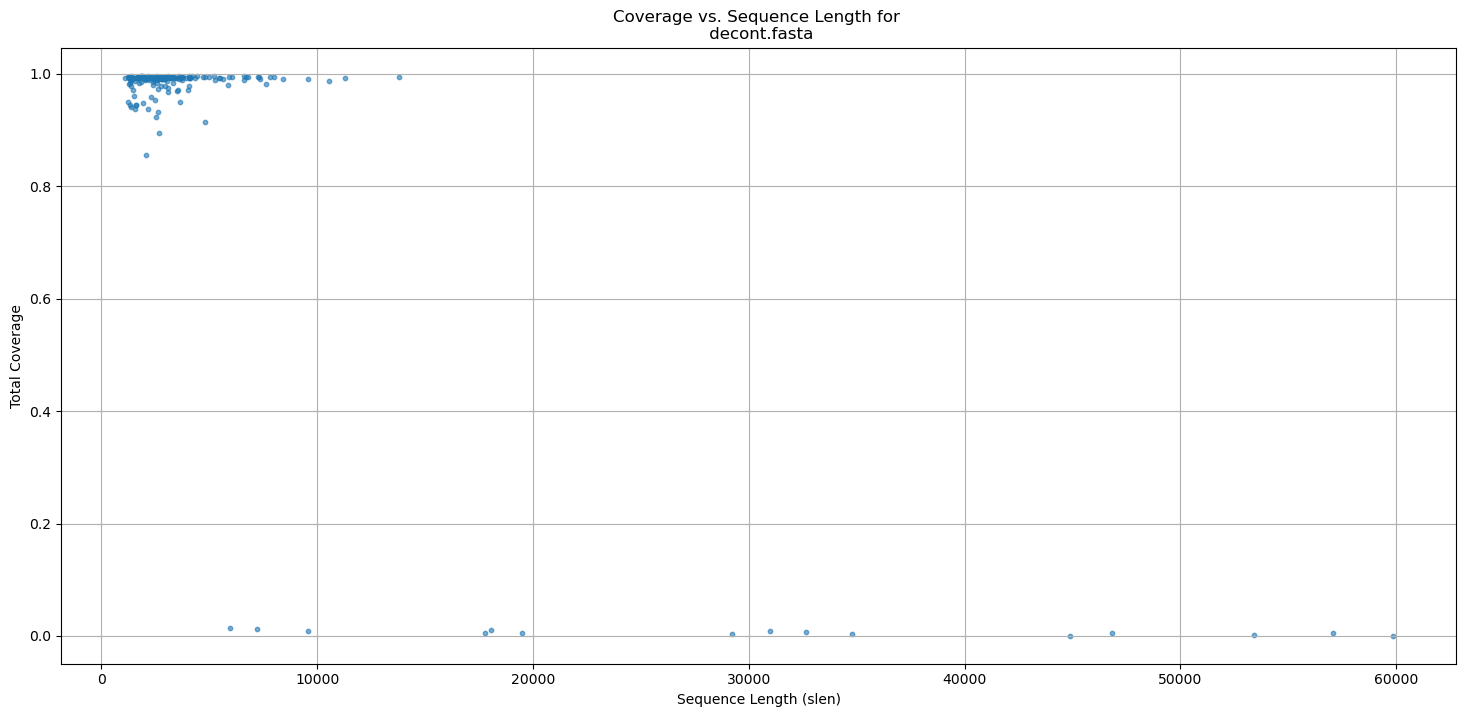

In [55]:
import matplotlib.pyplot as plt


print(f"Number of sequences: {plot_df.shape[0]}")
print(f"Median size: {plot_df['slen'].median()}")
print(f"Mean size: {plot_df['slen'].mean()} ")
print(f"Median coverage: {plot_df['coverage_fraction'].median()}")
print(f"Mean coverage: {plot_df['coverage_fraction'].mean()}")

plt.figure(figsize=(18, 8))
plt.scatter(plot_df['slen'], plot_df['coverage_fraction'], alpha=0.6, s=10)
plt.xlabel('Sequence Length (slen)')
plt.ylabel('Total Coverage')
plt.title(f'Coverage vs. Sequence Length for \n {os.path.basename(input_subject_sequences)}')
plt.grid(True)
#plt.savefig(output_plot_path)
plt.show()

# Contamined Sequences results qlne/len > 0.9

Number of sequences: 1524
Median size: 2301.5
Mean size: 3362.3622047244094 
Median coverage: 0.6366264619178821
Mean coverage: 0.6144202052061613


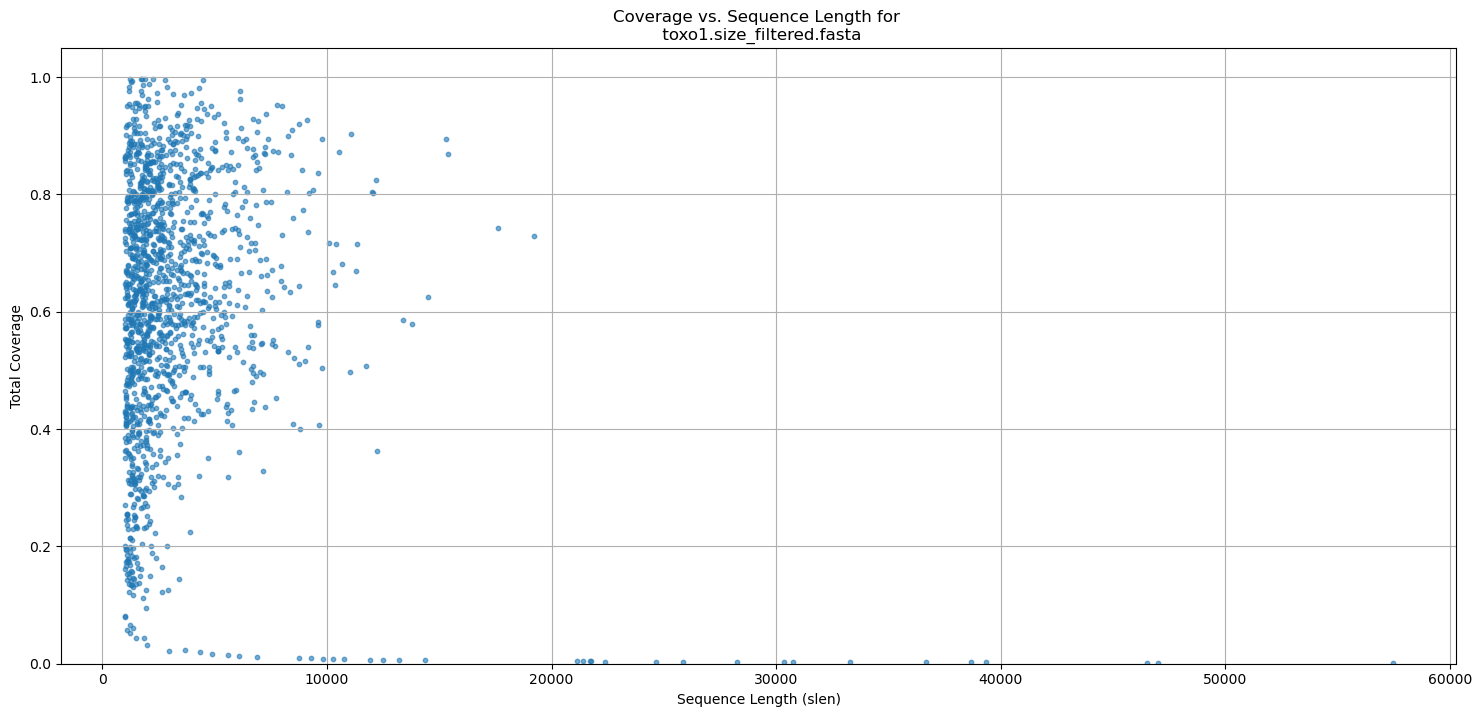

In [68]:
import matplotlib.pyplot as plt

print(f"Number of sequences: {plot_df.shape[0]}")
print(f"Median size: {plot_df['slen'].median()}")
print(f"Mean size: {plot_df['slen'].mean()} ")
print(f"Median coverage: {plot_df['coverage_fraction'].median()}")
print(f"Mean coverage: {plot_df['coverage_fraction'].mean()}")

plt.figure(figsize=(18, 8))
plt.scatter(plot_df['slen'], plot_df['coverage_fraction'], alpha=0.6, s=10)
plt.xlabel('Sequence Length (slen)')
plt.ylabel('Total Coverage')
plt.title(f'Coverage vs. Sequence Length for \n {os.path.basename(input_subject_sequences)}')
#plt.xlim((0,14200))
plt.ylim((0,1.05))

plt.grid(True)

#plt.savefig(output_plot_path)
plt.show()

# Contamined Sequences results

Number of sequences: 1747
Median size: 2611.0
Mean size: 5765.014882655982 
Median coverage: 0.6773533424283765
Mean coverage: 0.6028275203394099


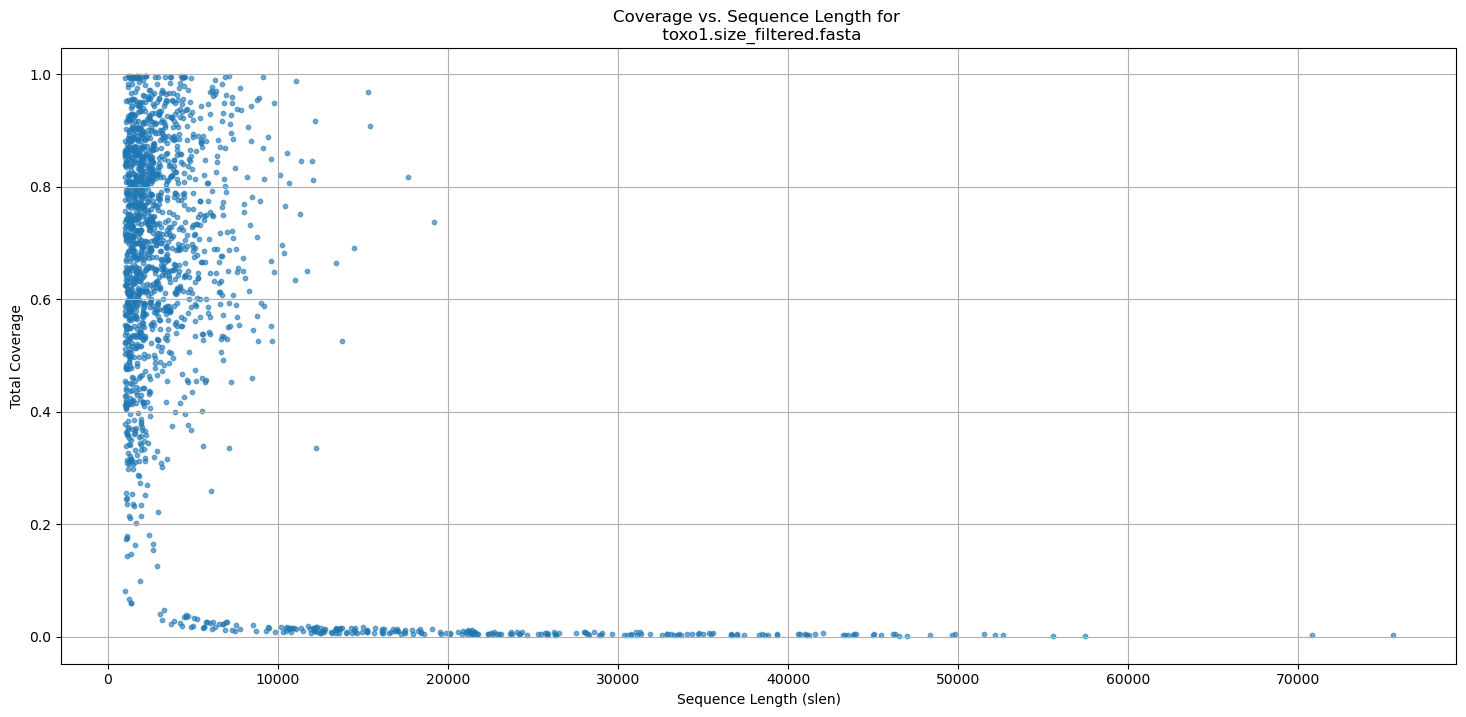

In [51]:
import matplotlib.pyplot as plt


print(f"Number of sequences: {plot_df.shape[0]}")
print(f"Median size: {plot_df['slen'].median()}")
print(f"Mean size: {plot_df['slen'].mean()} ")
print(f"Median coverage: {plot_df['coverage_fraction'].median()}")
print(f"Mean coverage: {plot_df['coverage_fraction'].mean()}")

plt.figure(figsize=(18, 8))
plt.scatter(plot_df['slen'], plot_df['coverage_fraction'], alpha=0.6, s=10)
plt.xlabel('Sequence Length (slen)')
plt.ylabel('Total Coverage')
plt.title(f'Coverage vs. Sequence Length for \n {os.path.basename(input_subject_sequences)}')
plt.grid(True)
#plt.savefig(output_plot_path)
plt.show()